# Linear SDOF PINN - n-step ahead prediction

## Problem overview

The example problem we solve here is the SDOF cubic oscillator:
$$
m \ddot{x} + c\dot{x} + kx = 0~, \qquad \ddot{x} + \tilde{c}\dot{x} + \tilde{k}x = 0~, \qquad \tilde{\bullet}=\frac{\bullet}{m}
$$
with the initial conditions
$$
x(0) = x_0~~,~~\dot{x}(0) = \dot{x}_0
$$

The aim is to predict the output at one-step ahead, using the previous displacement and velocity;
$$
x_{n+1} = f(x_{n},\dot{x}_{n})
$$

For notation with the neural networks, we will denote,
$$
y = x_{n+1}, \qquad \mathbf{x} = \{ x_{n},\dot{x}_{n} \}
$$

In [12]:
from osa_pinn import bbnn, osa_pinn_sdof, normalise
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch
import torch.nn as nn

from scipy.stats import qmc

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


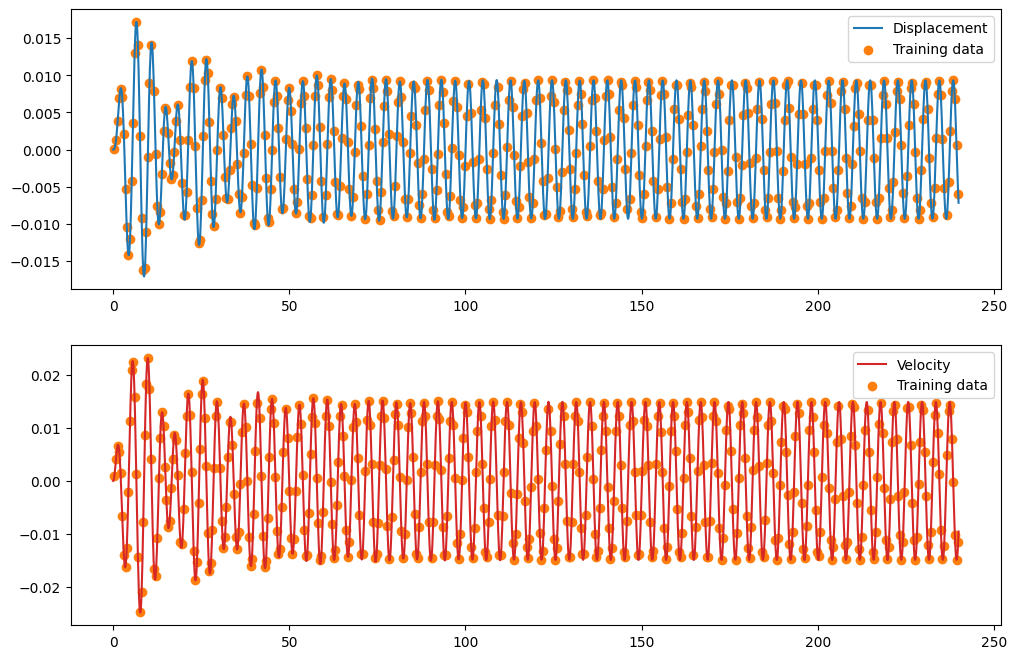

In [13]:
nt = 2048
time = np.linspace(0,240,nt)

F0 = 0.1  # N

excitation = {
    "type" : "sinusoid",
    "F0" : F0,
    "w" : 1.6  # rad/s
}

# excitation = {
#     "type" : "rand_phase_ms",
#     "F0" : F0,
#     "freqs" :   np.array([0.7, 0.85, 1.6, 1.8]),
#     "Sx" :      np.array([1.0, 1.0, 1.0, 1.0])
# }

# excitation = {
#     "type" : "white_gaussian",
#     "F0" : F0,
#     "offset" :   0.0
# }

# excitation = {
#     "type" : "sine_sweep",
#     "F0" : F0,
#     "w" :   np.array([0.4, 2.8]),
#     "scale" :  "linear"
# }

F = generate_excitation(time, **excitation)
excitation["F"] = F.reshape(-1)
### Generate training/ground truth data
m = 10.0
c = 1.0
k = 15.0
k3 = 20.0
excitation["F_tild"] = torch.tensor(excitation["F"]/m, dtype=torch.float32)

wn = np.sqrt(k/m)
zeta = c/(2*m*wn)
wd = wn*np.sqrt(1-zeta**2)

k_tild = k/m
c_tild = c/m
k3_tild = k3/m

config = {
    "time_" : time,
    "nonlinearity" : "cubic",
    "m_norm" : True,
    "params" : {
        "k_tild" : k_tild,
        "c_tild" : c_tild,
        "k3_tild" : k3_tild
    },
    "init_conds" : {
        "x0" : 0.0,
        "v0" : 0.0
    },
    "forcing" : excitation
}

xx, vv = sdof_solution(time, **config)
time = torch.tensor(time).view(-1,1).to(torch.float32)

# slice out a number of points
sampler = qmc.Sobol(d=1)
sub_ind = np.sort(sampler.integers(l_bounds=nt, n=int(nt/4)), axis=0)
# sub_ind = np.arange(0, int(nt/1), 3)

t_data = time[sub_ind]
x_data = xx[sub_ind]
v_data = vv[sub_ind]
F_data = excitation['F_tild'][sub_ind]

T = t_data[1].item()-t_data[0].item()

fig, axs = plt.subplots(2,1,figsize=(12,8))

axs[0].plot(time, xx, color="tab:blue", label="Displacement")
axs[0].scatter(t_data, x_data, color="tab:orange", label="Training data")
axs[0].legend()
# axs02 = axs[0].twinx()
# axs02.plot(time, excitation['F_tild'], color="tab:olive", alpha=0.4, label="Forcing")
# axs02.scatter(t_data, F_data, color="tab:cyan", label="Training data")
# axs02.legend()

axs[1].plot(time, vv, color="tab:red", label="Velocity")
axs[1].scatter(t_data, v_data, color="tab:orange", label="Training data")
axs[1].legend()

Normalise and create some plotting functions

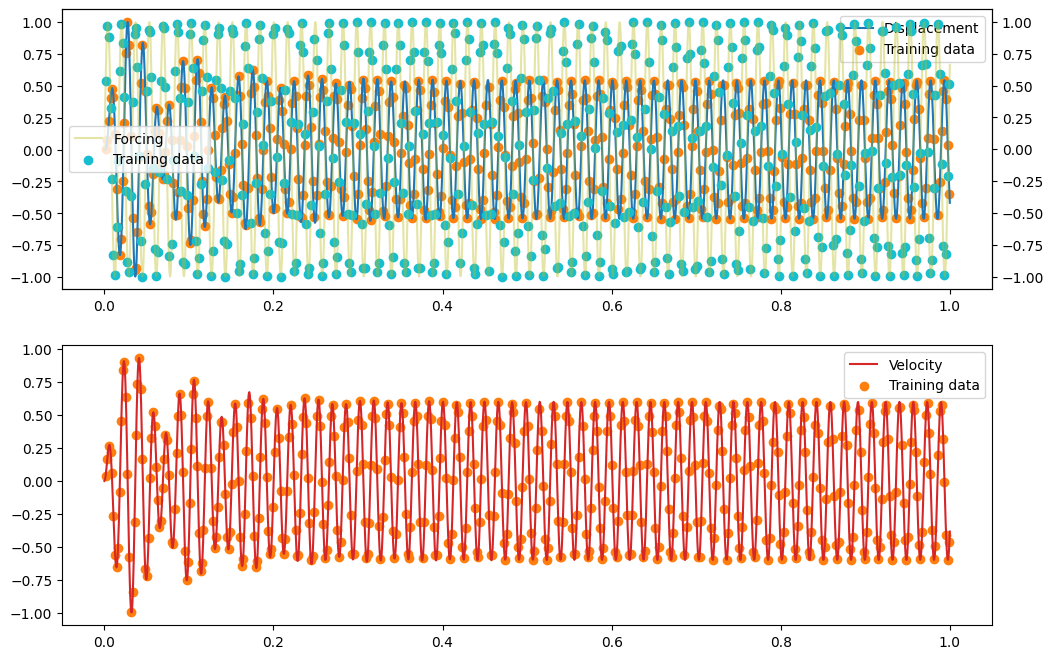

In [14]:
t_hat, alpha_t = normalise(time, "range")
x_hat_gt, alpha_x = normalise(xx, "range")
v_hat_gt, alpha_v = normalise(vv, "range")
F_hat_gt, alpha_F = normalise(excitation['F_tild'], "range")

t_data = t_hat[sub_ind]
x_data = x_hat_gt[sub_ind]
v_data = v_hat_gt[sub_ind]
F_data = F_hat_gt[sub_ind]

T_hat = t_data[1].item()-t_data[0].item()

fig, axs = plt.subplots(2,1,figsize=(12,8))

axs[0].plot(t_hat, x_hat_gt, color="tab:blue", label="Displacement")
axs[0].scatter(t_data, x_data, color="tab:orange", label="Training data")
axs[0].legend()
axs02 = axs[0].twinx()
axs02.plot(t_hat, F_hat_gt, color="tab:olive", alpha=0.4, label="Forcing")
axs02.scatter(t_data, F_data, color="tab:cyan", label="Training data")
axs02.legend()

axs[1].plot(t_hat, v_hat_gt, color="tab:red", label="Velocity")
axs[1].scatter(t_data, v_data, color="tab:orange", label="Training data")
axs[1].legend()

In [15]:
def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    labels = ["L_obs", "L_ic", "L_ode", "L"]
    colors = ["tab:blue", "tab:red", "tab:green", "black"]
    ax.cla()
    for i in range(len(labels)):
        ax.plot(np.arange(1,n_epoch+1),loss_hist[:,i],color=colors[i],label=labels[i])
    ax.set_yscale('log')
    ax.legend()

def plot_result(ax, ground_truth, data, prediction, alphas):
    ax.cla()
    ax.plot(ground_truth["t_hat"]*alphas["t"], ground_truth["x_hat"]*alphas["x"], color="grey", linewidth=1, alpha=0.8, label="Exact solution")
    ax.plot(prediction["t_hat"]*alphas["t"], prediction["x_hat"]*alphas["x"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
    ax.scatter(data["t_hat"]*alphas["t"], data["x_hat"]*alphas["x"], s=20, color="tab:orange", alpha=0.4, label='Training data')
    l = ax.legend(frameon=False, fontsize="large")
    xL = torch.amax(ground_truth["t_hat"])*alphas["t"]
    yL = torch.amax(torch.abs(ground_truth["x_hat"]))*alphas["x"]
    ax.set_xlim(-0.05*xL, 1.05*xL)
    ax.set_ylim(-1.1*yL, 1.1*yL)

ground_truth = {
    "t_hat" : t_hat,
    "x_hat" : x_hat_gt,
    "v_hat" : v_hat_gt,
    "F_hat" : F_hat_gt
}

data = {
    "t_hat" : t_data,
    "x_hat" : x_data,
    "v_hat" : v_data,
    "F_hat" : F_data,
    "sub_ind" : sub_ind
}

## PINN

$$
\mathcal{L}(x_0,v_0,t;\mathbf{\theta}) := \mathcal{L}_{obs} + \mathcal{L}_{ic} + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_{obs} = \langle \hat{x}^* - \mathcal{N}_{\hat{x}} \rangle _{\Omega\in\{t=T\}}, \qquad
\mathcal{L}_{ic} = \langle \alpha_{v}\hat{v}_0 - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\mathcal{N}_{\hat{x}} \rangle _{\Omega\in\{t=0\}}
$$
$$
\mathcal{L}_{ode} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} - \eta \hat{F}\rangle _{\Omega_d}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

Epoch : 500000 ---- Loss: 2.94e-03


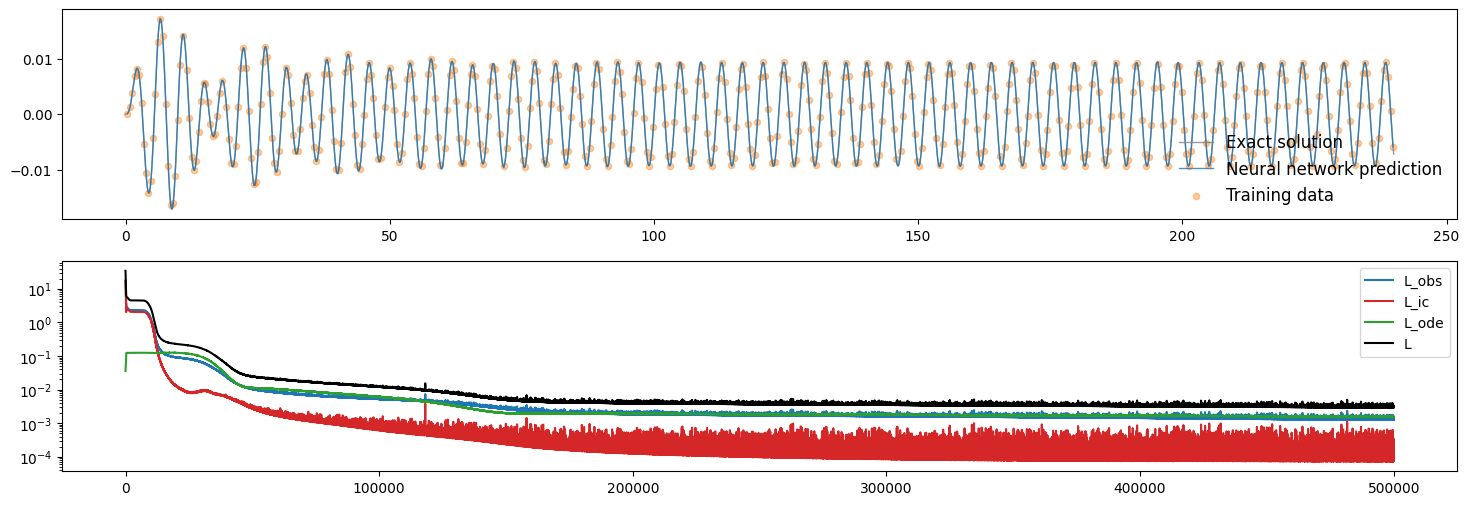

In [16]:
alpha_c = c_tild*10
alpha_k = k_tild*10
alpha_k3 = k3_tild*10
alphas = {
    "c" : alpha_c,
    "k" : alpha_k,
    "k3" : alpha_k3,
    "t" : alpha_t,
    "x" : alpha_x,
    "v" : alpha_v,
    "F" : alpha_F
}

nct = 16  # number of collocation points in time window

torch.manual_seed(123)

osa_config = {
    "n_input" : 4,
    "n_output" : 1,
    "n_hidden" : 16,
    "n_layers" : 2,
    "T" : T,
    "T_hat" : T_hat,
    "nct" : nct,
    "nonlinearity" : config["nonlinearity"],
    "phys_params" : {
        "par_type" : "constant",
        "k": k_tild,
        "c" : c_tild,
        "k3" : k3_tild
    },
    "alphas" : alphas,
    "ode_norm_Lambda" : alpha_x.item(),
    "forcing" : config["forcing"]
}

# configure PINN
osa_model = osa_pinn_sdof(osa_config)
t_pred = osa_model.set_colls_and_obs(t_data, x_data, v_data, F_data)

# configure optimiser
learning_rate = 2e-4
betas = (0.95,0.999)
optimizer = torch.optim.Adam(osa_model.parameters(), lr=learning_rate, betas=betas)

# learning_rate = 5e-3
# max_iter = 50
# optimizer = torch.optim.LBFGS(osa_model.parameters(), lr=learning_rate, max_iter=max_iter)

fig, axs = plt.subplots(2,1,figsize=(18,6),facecolor='w')
print_step = 200
loss_hist=[]
lambds = {
    'obs' : 100.0,
    'ic' : 100.0,
    'ode' : 500.0
}

epochs = int(500e3)
for i in tqdm(range(epochs)):

    # def closure():
    #     optimizer.zero_grad()
    #     loss, losses = osa_model.loss_func(lambds)
    #     loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    #     loss.backward()
    #     return loss
    
    # optimizer.step(closure)

    optimizer.zero_grad()
    loss, losses = osa_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()

    if (i+1) % print_step == 0:

        x_pred = osa_model.predict().detach()

        prediction = {
            "t_hat" : t_pred,
            "x_hat" : x_pred
        }

        plot_result(axs[0], ground_truth, data, prediction, alphas)

        plot_joint_loss_hist(axs[1], np.array(loss_hist))

        display.clear_output(wait=True)
        display.display(plt.gcf())
        match osa_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss_hist[i][-1],osa_model.phys_params[0]*alphas['c'],osa_model.phys_params[1]*alphas['k']))

display.clear_output()
match osa_model.param_type:
    case "constant":
        tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
    case "variable":
        tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss_hist[i][-1],osa_model.phys_params[0]*alphas['c'],osa_model.phys_params[1]*alphas['k']))
        

In [17]:
result_data = {
    'epoch' : i,
    'gt_config' : config,
    'osa_config' : osa_config,
    'model' : osa_model.state_dict(),
    'loss' : loss_hist,
    'ground_truth' : ground_truth,
    'data' : data,
    'prediction' : prediction,
    'alphas' : alphas
}

torch.save(result_data, 'results/osa_sine_cubic.pth')

In [18]:
# checkpoint = {
#     'epoch' : i,
#     'model' : osa_model.state_dict(),
#     'optimizer' : optimizer.state_dict(),
#     'loss' : loss_hist
# }

# torch.save(checkpoint,'checkpoints/osa_forced_linear.pth')